In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

database = 'database.sqlite'
conexao = sqlite3.connect(database)

## Etapa 1: Seleção de Dados

In [2]:
df_jogadores = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conexao)
df_jogadores

,name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


In [3]:
df_jogadores = pd.read_sql("SELECT * FROM Player", conexao)

df_jogadores.head(3)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163


In [4]:
df_atributos_jogador = pd.read_sql("SELECT * FROM Player_Attributes", conexao)

df_atributos_jogador.head(3)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0


In [5]:
# Selecionando tabelas e colunas no formato SQLite e convertendo para um objeto dataframe pela biblioteca Pandas
query = """SELECT * FROM Player_Attributes a
           INNER JOIN (SELECT player_name, player_api_id AS p_id FROM Player) b ON a.player_api_id = b.p_id;"""

df_jogadores = pd.read_sql(query, conexao)

df_jogadores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 44 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accele

In [6]:
atributos_nao_usados = drop_cols = ['id','player_fifa_api_id','date','preferred_foot',
             'attacking_work_rate','defensive_work_rate']

n_registros = df_jogadores.shape

df_jogadores = df_jogadores.drop(atributos_nao_usados, axis=1)

print('Dimensões do data frame antes do tratamento (Linhas x Colunas): {}'.format(n_registros))
print('Dimensões do data frame após tratamento(Linhas x Colunas): {}'.format(df_jogadores.shape))

Dimensões do data frame antes do tratamento (Linhas x Colunas): (183978, 44)
Dimensões do data frame após tratamento(Linhas x Colunas): (183978, 38)


## Etapa 2: Pré-Processamento

In [7]:
n_registros = df_jogadores.shape[0]

# Removendo registros com repetições
df_jogadores = df_jogadores.drop_duplicates(subset='player_api_id', keep='first')

print('Número de registros antes da limpeza: {}'.format(n_registros))
print('Número de registros após da limpeza: {}'.format(df_jogadores.shape[0]))
print('Número de registros duplicados: removidos: {}'.format((n_registros - df_jogadores.shape[0])))




Número de registros antes da limpeza: 183978
Número de registros após da limpeza: 11060
Número de registros duplicados: removidos: 172918


In [8]:
# Checando valores nulos
df_jogadores.isnull().any().any()

True

In [9]:
n_registros = df_jogadores.shape[0]

df_jogadores = df_jogadores.dropna()
print('Número de registros removidos: {}'.format(n_registros - df_jogadores.shape[0]))

Número de registros removidos: 478


In [10]:
# Reorganizando index
df_jogadores = df_jogadores.reset_index()

df_jogadores = df_jogadores.drop("index",1)

## Etapa 3: Transformação

In [11]:
df_transformado = df_jogadores

df_transformado = df_transformado.drop(['player_api_id','overall_rating','potential','player_name', 'p_id'], axis=1)

df_transformado.head()

,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
2,64.0,58.0,60.0,66.0,52.0,66.0,67.0,63.0,62.0,67.0,...,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
3,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,...,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0
4,46.0,34.0,73.0,65.0,33.0,47.0,42.0,25.0,58.0,58.0,...,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0


In [87]:
df_transformado.columns.values

array(['crossing', 'finishing', 'heading_accuracy', 'short_passing',
       'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping',
       'stamina', 'strength', 'long_shots', 'aggression', 'interceptions',
       'positioning', 'vision', 'penalties', 'marking', 'standing_tackle',
       'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking',
       'gk_positioning', 'gk_reflexes'], dtype=object)

In [24]:
# K-Means implementado em Python. Autor: Jardel Casteluber

def kmeans(data_frame, k, centroides_iniciais, max_iteracoes=500):

    count = 0
    dados_centroides = []
    centroides = centroides_iniciais[:]
    clusters_ultima_iteracao = None

    for iteracoes in range(max_iteracoes):
        count = count + 1

        # 1. Atribuir cada registro ao centroide mais próximo
        distancia_euclidiana = pairwise_distances(
            data_frame, centroides, metric="euclidean")

        membros_atribuidos = np.argmin(distancia_euclidiana, axis=1)
          

        # 2. Calcular novo centroide para cada cluster (k) .
        centroides = []
        for i in range(k):
            membros_cluster = data_frame[membros_atribuidos == i]

            centroide_recalculado = membros_cluster.mean(axis=0)

            centroides.append(centroide_recalculado)

        centroides = np.array(centroides)
        

        # Mecanismo de checagem de convergência para finalizar o algoritmo
        if (
            clusters_ultima_iteracao is not None
            and (clusters_ultima_iteracao == membros_atribuidos).all()
        ):           
            break

        clusters_ultima_iteracao = membros_atribuidos[:]
        dados_centroides.append(centroides)
        
    print('Quantidade de iterações: {}'.format(count))
    return dados_centroides, membros_atribuidos

In [17]:
k = 4

# Obtendo centroides
data_frame = df_transformado.values

n = data_frame.shape[0]

indices_aleatorios = np.random.randint(0, n, k)

centroides_iniciais = data_frame[indices_aleatorios, :]


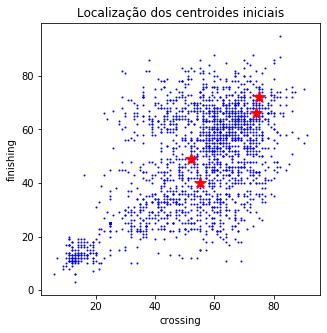

In [21]:
# Plotando centroides com amostra de dados    
plt.figure(figsize=(5,5))
for i in range(2000):
    plt.scatter(data_frame[i, 0], data_frame[i, 1], s=1, color = 'b')        

plt.scatter(centroides_iniciais[:,0], centroides_iniciais[:,1], marker='*', c='r', s=150)

plt.title('Localização dos centroides iniciais')
plt.xlabel('crossing')
plt.ylabel('finishing')
plt.show()

In [33]:
# Iniciando K-Means
dados_centroides, clusters_agrupados = kmeans(df_transformado, k, centroides_iniciais)


Quantidade de iterações: 21


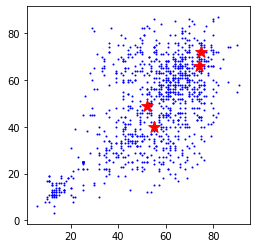

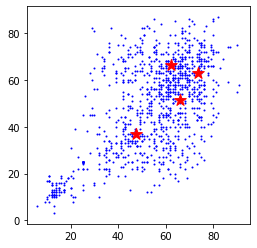

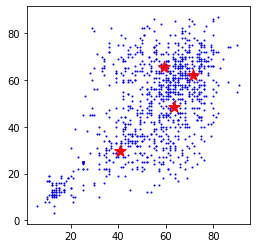

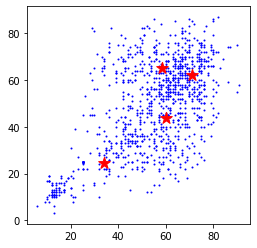

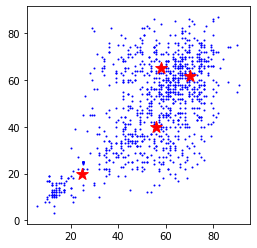

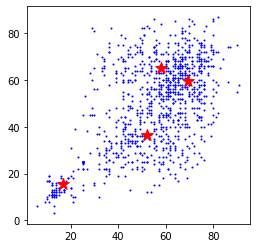

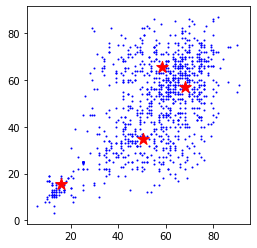

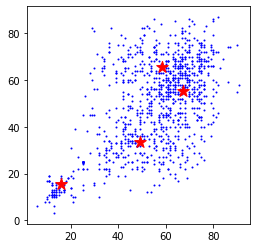

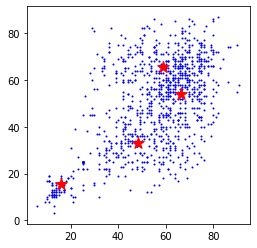

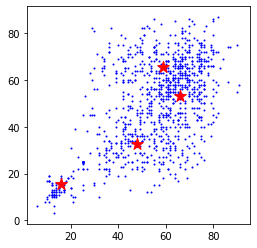

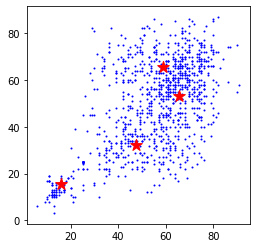

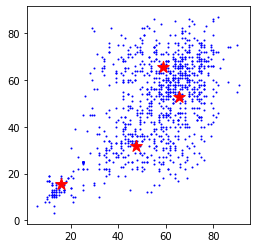

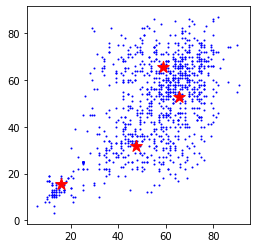

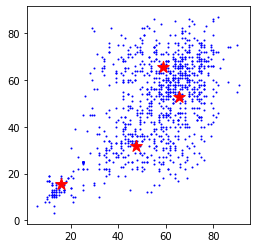

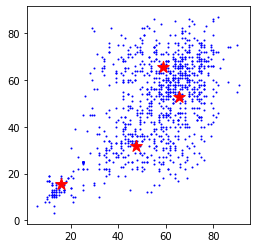

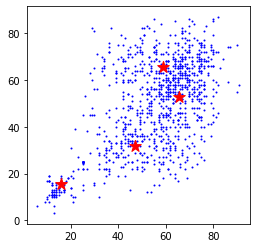

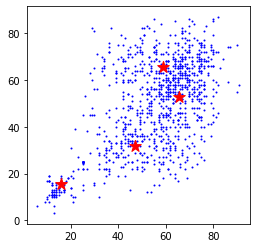

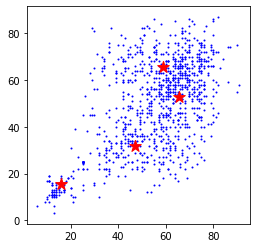

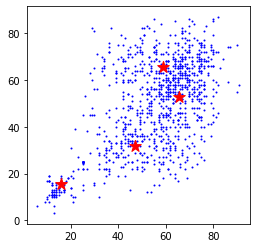

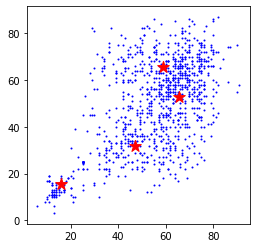

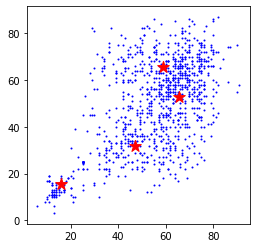

In [38]:
# Plotando centroides após K-means   
plt.figure(figsize=(4,4))
for i in range(1000):
    plt.scatter(data_frame[i, 0], data_frame[i, 1], s=1, color = 'b')       

plt.scatter(centroides_iniciais[:,0], centroides_iniciais[:,1], marker='*', c='r', s=150)
plt.show()

for centroid in dados_centroides:
    plt.figure(figsize=(4,4))
    for i in range(1000):        
        plt.scatter(data_frame[i, 0], data_frame[i, 1], s=1, color = 'b') 
    
    plt.scatter(centroid[:,0], centroid[:,1], marker='*', c='r', s=150)    
    plt.show()

In [42]:
df_kmeans = pd.DataFrame(clusters_agrupados)

df_jogadores['cluster'] = df_kmeans

df_jogadores.head(5)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
0,505942,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,...,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,505942,1
1,155782,74.0,76.0,80.0,53.0,58.0,71.0,40.0,73.0,70.0,...,75.0,78.0,14.0,7.0,9.0,9.0,12.0,Aaron Cresswell,155782,0
2,162549,65.0,67.0,64.0,58.0,60.0,66.0,52.0,66.0,67.0,...,22.0,24.0,16.0,11.0,12.0,9.0,13.0,Aaron Doran,162549,2
3,30572,69.0,69.0,57.0,21.0,68.0,65.0,48.0,56.0,38.0,...,71.0,68.0,15.0,12.0,13.0,12.0,11.0,Aaron Galindo,30572,1
4,23780,70.0,70.0,46.0,34.0,73.0,65.0,33.0,47.0,42.0,...,73.0,71.0,8.0,6.0,16.0,12.0,11.0,Aaron Hughes,23780,1


In [43]:
jogadores_cluster_0 = df_jogadores.cluster == 0.0
grupo_0 = df_jogadores[jogadores_cluster_0]

jogadores_cluster_1 = df_jogadores.cluster == 1.0
grupo_1 = df_jogadores[jogadores_cluster_1]

jogadores_cluster_2 = df_jogadores.cluster == 2.0
grupo_2 = df_jogadores[jogadores_cluster_2]

jogadores_cluster_3 = df_jogadores.cluster == 3.0
grupo_3 = df_jogadores[jogadores_cluster_3]

In [44]:
# Calculando média para cada registro de cada cluster
lista_0 = []
lista_1 = []
lista_2 = []
lista_3 = []

colunas = ['potential',  'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes']
for elemento in colunas:
    lista_0.append(grupo_0[elemento].mean())
    lista_1.append(grupo_1[elemento].mean())
    lista_2.append(grupo_2[elemento].mean())
    lista_3.append(grupo_3[elemento].mean())


In [45]:
# Preparando dados para plotagem
media_0 = pd.DataFrame(lista_0)
media_0 = media_0.transpose()
media_0.columns = colunas


media_1 = pd.DataFrame(lista_1)
media_1 = media_1.transpose()
media_1.columns = colunas


media_2 = pd.DataFrame(lista_2)
media_2 = media_2.transpose()
media_2.columns = colunas


media_3 = pd.DataFrame(lista_3)
media_3 = media_3.transpose()
media_3.columns = colunas


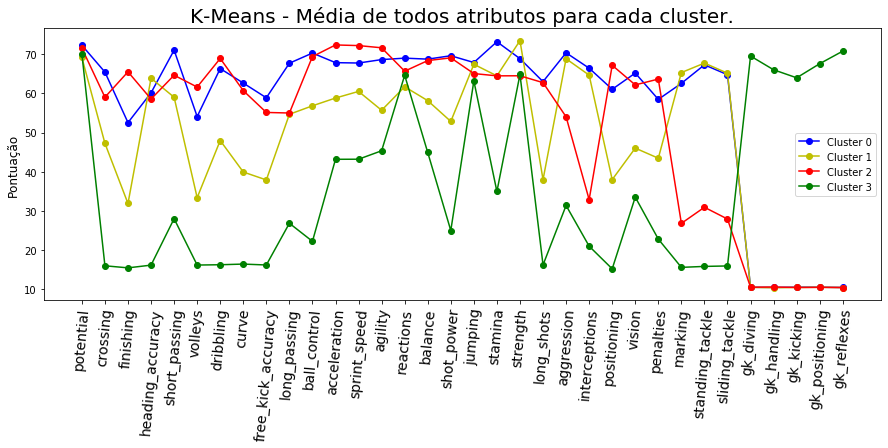

In [50]:
# Gráfico com média de cada atributo para cada um dos clusters
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)

ax1.set_xticks(range(0,34))
ax1.set_xticklabels(colunas, rotation=85, fontsize=14); 

ax1.plot(lista_0, color='b', label="Cluster 0",marker='o')
ax1.plot(lista_1, color='y', label="Cluster 1",marker='o')
ax1.plot(lista_2, color='r', label="Cluster 2",marker='o')
ax1.plot(lista_3, color='g', label="Cluster 3",marker='o')
plt.legend(loc='best')
plt.title("K-Means - Média de todos atributos para cada cluster.", fontsize=20)
plt.ylabel('Pontuação', fontsize=12)
plt.show()

In [51]:
grupo_0 = grupo_0.sort_values(by=['overall_rating'],ascending=False)
grupo_0.head(5)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
716,30955,88.0,88.0,79.0,73.0,54.0,92.0,74.0,90.0,80.0,...,57.0,56.0,6.0,13.0,6.0,13.0,7.0,Andres Iniesta,30955,0
9735,80562,88.0,88.0,60.0,38.0,82.0,79.0,63.0,68.0,61.0,...,91.0,89.0,9.0,12.0,5.0,9.0,10.0,Thiago Silva,80562,0
4662,36183,87.0,88.0,69.0,34.0,87.0,75.0,53.0,67.0,56.0,...,90.0,91.0,7.0,12.0,15.0,6.0,5.0,Jerome Boateng,36183,0
6114,31097,87.0,87.0,78.0,71.0,55.0,86.0,75.0,86.0,79.0,...,75.0,73.0,13.0,9.0,7.0,14.0,9.0,Luka Modric,31097,0
3494,31921,87.0,89.0,84.0,81.0,76.0,84.0,76.0,87.0,87.0,...,65.0,62.0,15.0,15.0,11.0,5.0,6.0,Gareth Bale,31921,0


In [52]:
grupo_1 = grupo_1.sort_values(by=['overall_rating'],ascending=False)
grupo_1.head(5)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
3692,41884,86.0,86.0,52.0,33.0,84.0,49.0,45.0,52.0,56.0,...,90.0,90.0,3.0,3.0,2.0,4.0,3.0,Giorgio Chiellini,41884,1
654,30902,85.0,85.0,40.0,27.0,76.0,65.0,35.0,60.0,50.0,...,90.0,88.0,4.0,2.0,4.0,2.0,4.0,Andrea Barzagli,30902,1
7279,19327,85.0,85.0,48.0,43.0,83.0,64.0,51.0,62.0,32.0,...,90.0,89.0,12.0,6.0,10.0,13.0,12.0,Miranda,19327,1
4886,30627,84.0,84.0,42.0,46.0,90.0,66.0,55.0,45.0,44.0,...,87.0,84.0,14.0,5.0,6.0,15.0,8.0,John Terry,30627,1
5744,46539,84.0,84.0,54.0,32.0,84.0,75.0,35.0,62.0,22.0,...,87.0,85.0,13.0,11.0,9.0,11.0,7.0,Laurent Koscielny,46539,1


In [53]:
grupo_2 = grupo_2.sort_values(by=['overall_rating'],ascending=False)
grupo_2.head(5)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
5909,30981,94.0,94.0,80.0,93.0,71.0,88.0,85.0,96.0,89.0,...,23.0,21.0,6.0,11.0,15.0,14.0,8.0,Lionel Messi,30981,2
1908,30893,93.0,93.0,82.0,95.0,86.0,81.0,87.0,93.0,88.0,...,31.0,23.0,7.0,11.0,15.0,14.0,11.0,Cristiano Ronaldo,30893,2
7528,19533,90.0,94.0,72.0,88.0,62.0,78.0,83.0,94.0,78.0,...,24.0,33.0,9.0,9.0,15.0,15.0,11.0,Neymar,19533,2
6102,40636,90.0,90.0,77.0,90.0,77.0,82.0,87.0,88.0,86.0,...,45.0,38.0,27.0,25.0,31.0,33.0,37.0,Luis Suarez,40636,2
916,30834,89.0,89.0,80.0,85.0,51.0,85.0,86.0,93.0,86.0,...,26.0,26.0,10.0,8.0,11.0,5.0,15.0,Arjen Robben,30834,2


In [54]:
grupo_3 = grupo_3.sort_values(by=['overall_rating'],ascending=False)
grupo_3.head(5)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
6276,27299,90.0,90.0,15.0,13.0,25.0,48.0,11.0,16.0,14.0,...,10.0,11.0,85.0,87.0,91.0,90.0,87.0,Manuel Neuer,27299,3
2236,182917,87.0,90.0,17.0,13.0,21.0,31.0,13.0,13.0,21.0,...,21.0,13.0,88.0,81.0,86.0,85.0,89.0,David De Gea,182917,3
8200,30859,86.0,86.0,19.0,12.0,19.0,35.0,17.0,12.0,13.0,...,13.0,12.0,83.0,84.0,77.0,85.0,85.0,Petr Cech,30859,3
9743,170323,86.0,90.0,14.0,14.0,13.0,32.0,12.0,13.0,19.0,...,18.0,16.0,84.0,87.0,69.0,86.0,88.0,Thibaut Courtois,170323,3
4073,26295,85.0,85.0,13.0,10.0,10.0,27.0,11.0,10.0,11.0,...,10.0,18.0,87.0,82.0,68.0,81.0,88.0,Hugo Lloris,26295,3


In [74]:
meio_de_campo = grupo_0[['player_name', 'overall_rating','crossing','finishing', 'standing_tackle','sliding_tackle'
              ,'gk_diving', 'gk_positioning']]
meio_de_campo.sample(5)

,player_name,overall_rating,crossing,finishing,standing_tackle,sliding_tackle,gk_diving,gk_positioning
2212,David Addy,65.0,64.0,37.0,65.0,62.0,15.0,14.0
7407,Muhamed Demiri,57.0,47.0,42.0,57.0,55.0,10.0,6.0
6212,Maikel Kieftenbeld,70.0,61.0,58.0,68.0,73.0,13.0,10.0
10389,Ximo Navarro,74.0,72.0,36.0,71.0,79.0,7.0,9.0
9036,Samuel Stefanik,66.0,56.0,47.0,51.0,48.0,8.0,14.0


In [70]:
defesa = grupo_1[['player_name', 'overall_rating','crossing','finishing', 'standing_tackle','sliding_tackle'
              ,'gk_diving', 'gk_positioning']]
defesa.sample(5)

,player_name,overall_rating,crossing,finishing,standing_tackle,sliding_tackle,gk_diving,gk_positioning
4414,Jan Bamert,48.0,38.0,23.0,57.0,52.0,7.0,9.0
5879,Liam Grimshaw,48.0,33.0,32.0,54.0,49.0,13.0,12.0
3258,Florian Berisha,48.0,37.0,29.0,46.0,38.0,5.0,6.0
3642,Gianluca D'Angelo,47.0,33.0,28.0,51.0,62.0,8.0,6.0
8689,Robin Huser,47.0,34.0,27.0,48.0,50.0,13.0,11.0


In [76]:
ataque = grupo_2[['player_name', 'overall_rating','crossing','finishing', 'standing_tackle','sliding_tackle'
              ,'gk_diving', 'gk_positioning']]
ataque.sample(5)

,player_name,overall_rating,crossing,finishing,standing_tackle,sliding_tackle,gk_diving,gk_positioning
9731,Thiago Gentil,71.0,65.0,66.0,27.0,27.0,15.0,12.0
1454,Carlao,68.0,47.0,68.0,23.0,25.0,8.0,5.0
3083,Fahid Ben Khalfallah,71.0,66.0,63.0,33.0,30.0,12.0,15.0
1502,Carlos Reina Aranda,69.0,56.0,65.0,35.0,22.0,14.0,5.0
1414,Caio,74.0,75.0,72.0,18.0,22.0,14.0,14.0


In [78]:
goleiro = grupo_3[['player_name', 'overall_rating','crossing','finishing', 'standing_tackle','sliding_tackle'
              ,'gk_diving', 'gk_positioning']]
goleiro.sample(5)

,player_name,overall_rating,crossing,finishing,standing_tackle,sliding_tackle,gk_diving,gk_positioning
10047,Ulisse Pelloni,55.0,20.0,25.0,21.0,25.0,60.0,49.0
2283,David Meul,62.0,12.0,11.0,10.0,13.0,62.0,66.0
6449,Marco Silvestri,69.0,12.0,20.0,18.0,16.0,79.0,67.0
7596,Nicolas Douchez,75.0,18.0,10.0,13.0,16.0,75.0,74.0
6391,Marco Amelia,70.0,19.0,8.0,12.0,13.0,71.0,69.0


In [79]:
data_frame = df_jogadores[['finishing', 'standing_tackle','sliding_tackle'
              ,'gk_diving', 'gk_positioning', 'cluster']]

cores=['b', 'y', 'r', 'g']

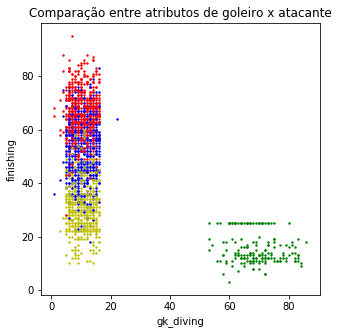

In [84]:
data_frame = df_jogadores[['gk_diving', 'finishing', 'cluster']]
data_frame = data_frame.values

plt.figure(figsize=(5,5))

for i in range(2000):
    plt.scatter(data_frame[i,0], data_frame[i,1], s=2, color=cores[int(data_frame[i,2])])


plt.title('Comparação entre atributos de goleiro x atacante')
plt.xlabel('gk_diving')
plt.ylabel('finishing')
plt.show()

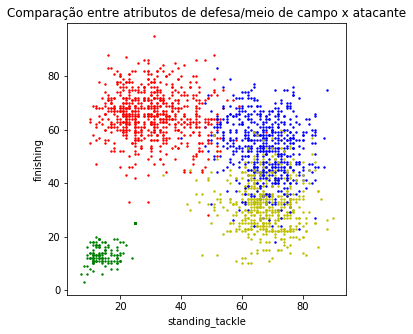

In [85]:
data_frame = df_jogadores[['standing_tackle', 'finishing', 'cluster']]
data_frame = data_frame.values

plt.figure(figsize=(5,5))

for i in range(2000):
    plt.scatter(data_frame[i,0], data_frame[i,1], s=2, color=cores[int(data_frame[i,2])])


plt.title('Comparação entre atributos de defesa/meio de campo x atacante')
plt.xlabel('standing_tackle')
plt.ylabel('finishing')
plt.show()

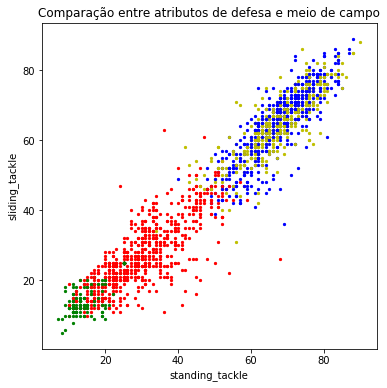

In [82]:
data_frame = df_jogadores[['standing_tackle', 'sliding_tackle', 'cluster']]
data_frame = data_frame.values

plt.figure(figsize=(6,6))

for i in range(2000):
    plt.scatter(data_frame[i,0], data_frame[i,1], s=5, color=cores[int(data_frame[i,2])])


plt.title('Comparação entre atributos de defesa e meio de campo')
plt.xlabel('standing_tackle')
plt.ylabel('sliding_tackle')
plt.show()